In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

In [2]:
# Get data
train = pd.read_csv("./train.csv")
print("train : " + str(train.shape))
test = pd.read_csv("./test.csv")
print("test : " + str(test.shape))

train : (1460, 81)
test : (1459, 80)


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
# Check for duplicates
idsUnique = len(set(train.Id))
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

idsUnique = len(set(test.Id))
idsTotal = test.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")


There are 0 duplicate IDs for 1460 total entries
There are 0 duplicate IDs for 1459 total entries


In [6]:
# Drop train Id column
train.drop("Id", axis = 1, inplace = True)

# Part test Id column
test_Id = test.Id

# Drop test Id column
test.drop("Id", axis = 1, inplace = True)

In [7]:
print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


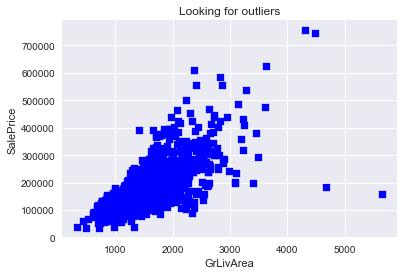

In [8]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train = train[train.GrLivArea < 4000]

(array([  96.,  539.,  445.,  211.,   96.,   37.,   20.,    6.,    3.,    3.]),
 array([  34900.,   93910.,  152920.,  211930.,  270940.,  329950.,
         388960.,  447970.,  506980.,  565990.,  625000.]),
 <a list of 10 Patch objects>)

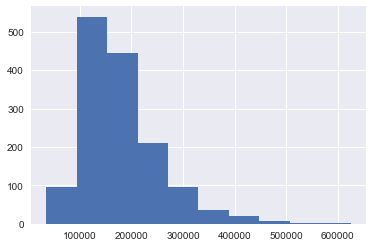

In [9]:
plt.hist(train.SalePrice)

In [10]:
# Log transform the target for official scoring
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

(array([   5.,   10.,   34.,  141.,  401.,  423.,  260.,  130.,   43.,    9.]),
 array([ 10.46027076,  10.74879454,  11.03731831,  11.32584209,
         11.61436587,  11.90288964,  12.19141342,  12.4799372 ,
         12.76846098,  13.05698475,  13.34550853]),
 <a list of 10 Patch objects>)

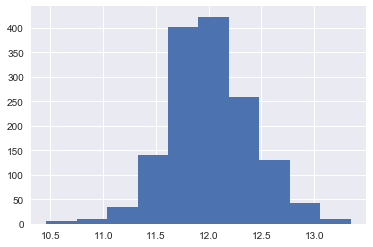

In [11]:
plt.hist(y)

In [12]:
# Handle missing values for features where median/mean or most common value doesn't make sense

# Alley : data description says NA means "no alley access"
train.loc[:, "Alley"] = train.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
train.loc[:, "BedroomAbvGr"] = train.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
train.loc[:, "BsmtQual"] = train.loc[:, "BsmtQual"].fillna("No")
train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")
train.loc[:, "BsmtFullBath"] = train.loc[:, "BsmtFullBath"].fillna(0)
train.loc[:, "BsmtHalfBath"] = train.loc[:, "BsmtHalfBath"].fillna(0)
train.loc[:, "BsmtUnfSF"] = train.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
train.loc[:, "CentralAir"] = train.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
train.loc[:, "Condition1"] = train.loc[:, "Condition1"].fillna("Norm")
train.loc[:, "Condition2"] = train.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
train.loc[:, "EnclosedPorch"] = train.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
train.loc[:, "ExterCond"] = train.loc[:, "ExterCond"].fillna("TA")
train.loc[:, "ExterQual"] = train.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
train.loc[:, "Fence"] = train.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
train.loc[:, "FireplaceQu"] = train.loc[:, "FireplaceQu"].fillna("No")
train.loc[:, "Fireplaces"] = train.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
train.loc[:, "Functional"] = train.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")
train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
train.loc[:, "HalfBath"] = train.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
train.loc[:, "HeatingQC"] = train.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
train.loc[:, "KitchenAbvGr"] = train.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
train.loc[:, "KitchenQual"] = train.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
train.loc[:, "LotShape"] = train.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
train.loc[:, "MiscFeature"] = train.loc[:, "MiscFeature"].fillna("No")
train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
train.loc[:, "OpenPorchSF"] = train.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
train.loc[:, "PavedDrive"] = train.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
train.loc[:, "PoolQC"] = train.loc[:, "PoolQC"].fillna("No")
train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
train.loc[:, "SaleCondition"] = train.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
train.loc[:, "ScreenPorch"] = train.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
train.loc[:, "TotRmsAbvGrd"] = train.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
train.loc[:, "Utilities"] = train.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
train.loc[:, "WoodDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)

In [13]:
# Handle missing values for features where median/mean or most common value doesn't make sense

# Alley : data description says NA means "no alley access"
test.loc[:, "Alley"] = test.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
test.loc[:, "BedroomAbvGr"] = test.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
test.loc[:, "BsmtQual"] = test.loc[:, "BsmtQual"].fillna("No")
test.loc[:, "BsmtCond"] = test.loc[:, "BsmtCond"].fillna("No")
test.loc[:, "BsmtExposure"] = test.loc[:, "BsmtExposure"].fillna("No")
test.loc[:, "BsmtFinType1"] = test.loc[:, "BsmtFinType1"].fillna("No")
test.loc[:, "BsmtFinType2"] = test.loc[:, "BsmtFinType2"].fillna("No")
test.loc[:, "BsmtFullBath"] = test.loc[:, "BsmtFullBath"].fillna(0)
test.loc[:, "BsmtHalfBath"] = test.loc[:, "BsmtHalfBath"].fillna(0)
test.loc[:, "BsmtUnfSF"] = test.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
test.loc[:, "CentralAir"] = test.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
test.loc[:, "Condition1"] = test.loc[:, "Condition1"].fillna("Norm")
test.loc[:, "Condition2"] = test.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
test.loc[:, "EnclosedPorch"] = test.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
test.loc[:, "ExterCond"] = test.loc[:, "ExterCond"].fillna("TA")
test.loc[:, "ExterQual"] = test.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
test.loc[:, "Fence"] = test.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
test.loc[:, "FireplaceQu"] = test.loc[:, "FireplaceQu"].fillna("No")
test.loc[:, "Fireplaces"] = test.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
test.loc[:, "Functional"] = test.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
test.loc[:, "GarageType"] = test.loc[:, "GarageType"].fillna("No")
test.loc[:, "GarageFinish"] = test.loc[:, "GarageFinish"].fillna("No")
test.loc[:, "GarageQual"] = test.loc[:, "GarageQual"].fillna("No")
test.loc[:, "GarageCond"] = test.loc[:, "GarageCond"].fillna("No")
test.loc[:, "GarageArea"] = test.loc[:, "GarageArea"].fillna(0)
test.loc[:, "GarageCars"] = test.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
test.loc[:, "HalfBath"] = test.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
test.loc[:, "HeatingQC"] = test.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
test.loc[:, "KitchenAbvGr"] = test.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
test.loc[:, "KitchenQual"] = test.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
test.loc[:, "LotFrontage"] = test.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
test.loc[:, "LotShape"] = test.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
test.loc[:, "MasVnrType"] = test.loc[:, "MasVnrType"].fillna("None")
test.loc[:, "MasVnrArea"] = test.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
test.loc[:, "MiscFeature"] = test.loc[:, "MiscFeature"].fillna("No")
test.loc[:, "MiscVal"] = test.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
test.loc[:, "OpenPorchSF"] = test.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
test.loc[:, "PavedDrive"] = test.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
test.loc[:, "PoolQC"] = test.loc[:, "PoolQC"].fillna("No")
test.loc[:, "PoolArea"] = test.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
test.loc[:, "SaleCondition"] = test.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
test.loc[:, "ScreenPorch"] = test.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
test.loc[:, "TotRmsAbvGrd"] = test.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
test.loc[:, "Utilities"] = test.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
test.loc[:, "WoodDeckSF"] = test.loc[:, "WoodDeckSF"].fillna(0)

In [14]:
# Some numerical features are actually really categories
train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [15]:
# Some numerical features are actually really categories
test = test.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [16]:
# Encode some categorical features as ordered numbers when there is information in the order
train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [17]:
# Encode some categorical features as ordered numbers when there is information in the order
test = test.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [18]:
# Create new features
# 1* Simplifications of existing features
train["SimplOverallQual"] = train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplOverallCond"] = train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplPoolQC"] = train.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
train["SimplGarageCond"] = train.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplGarageQual"] = train.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFunctional"] = train.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
train["SimplKitchenQual"] = train.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplHeatingQC"] = train.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplBsmtFinType1"] = train.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtFinType2"] = train.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtCond"] = train.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplBsmtQual"] = train.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplExterCond"] = train.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplExterQual"] = train.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

# 2* Combinations of existing features
# Overall quality of the house
train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]
# Overall quality of the garage
train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]
# Overall quality of the exterior
train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]
# Overall kitchen score
train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]
# Overall fireplace score
train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]
# Overall garage score
train["GarageScore"] = train["GarageArea"] * train["GarageQual"]
# Overall pool score
train["PoolScore"] = train["PoolArea"] * train["PoolQC"]
# Simplified overall quality of the house
train["SimplOverallGrade"] = train["SimplOverallQual"] * train["SimplOverallCond"]
# Simplified overall quality of the exterior
train["SimplExterGrade"] = train["SimplExterQual"] * train["SimplExterCond"]
# Simplified overall pool score
train["SimplPoolScore"] = train["PoolArea"] * train["SimplPoolQC"]
# Simplified overall garage score
train["SimplGarageScore"] = train["GarageArea"] * train["SimplGarageQual"]
# Simplified overall fireplace score
train["SimplFireplaceScore"] = train["Fireplaces"] * train["SimplFireplaceQu"]
# Simplified overall kitchen score
train["SimplKitchenScore"] = train["KitchenAbvGr"] * train["SimplKitchenQual"]
# Total number of bathrooms
train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
train["FullBath"] + (0.5 * train["HalfBath"])
# Total SF for house (incl. basement)
train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
# Total SF for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
train["3SsnPorch"] + train["ScreenPorch"]
# Has masonry veneer or not
train["HasMasVnr"] = train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
train["BoughtOffPlan"] = train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [19]:
# Create new features
# 1* Simplifications of existing features
test["SimplOverallQual"] = test.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
test["SimplOverallCond"] = test.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
test["SimplPoolQC"] = test.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
test["SimplGarageCond"] = test.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
test["SimplGarageQual"] = test.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
test["SimplFireplaceQu"] = test.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
test["SimplFireplaceQu"] = test.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
test["SimplFunctional"] = test.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
test["SimplKitchenQual"] = test.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
test["SimplHeatingQC"] = test.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
test["SimplBsmtFinType1"] = test.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
test["SimplBsmtFinType2"] = test.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
test["SimplBsmtCond"] = test.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
test["SimplBsmtQual"] = test.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
test["SimplExterCond"] = test.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
test["SimplExterQual"] = test.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

# 2* Combinations of existing features
# Overall quality of the house
test["OverallGrade"] = test["OverallQual"] * test["OverallCond"]
# Overall quality of the garage
test["GarageGrade"] = test["GarageQual"] * test["GarageCond"]
# Overall quality of the exterior
test["ExterGrade"] = test["ExterQual"] * test["ExterCond"]
# Overall kitchen score
test["KitchenScore"] = test["KitchenAbvGr"] * test["KitchenQual"]
# Overall fireplace score
test["FireplaceScore"] = test["Fireplaces"] * test["FireplaceQu"]
# Overall garage score
test["GarageScore"] = test["GarageArea"] * test["GarageQual"]
# Overall pool score
test["PoolScore"] = test["PoolArea"] * test["PoolQC"]
# Simplified overall quality of the house
test["SimplOverallGrade"] = test["SimplOverallQual"] * test["SimplOverallCond"]
# Simplified overall quality of the exterior
test["SimplExterGrade"] = test["SimplExterQual"] * test["SimplExterCond"]
# Simplified overall pool score
test["SimplPoolScore"] = test["PoolArea"] * test["SimplPoolQC"]
# Simplified overall garage score
test["SimplGarageScore"] = test["GarageArea"] * test["SimplGarageQual"]
# Simplified overall fireplace score
test["SimplFireplaceScore"] = test["Fireplaces"] * test["SimplFireplaceQu"]
# Simplified overall kitchen score
test["SimplKitchenScore"] = test["KitchenAbvGr"] * test["SimplKitchenQual"]
# Total number of bathrooms
test["TotalBath"] = test["BsmtFullBath"] + (0.5 * test["BsmtHalfBath"]) + \
test["FullBath"] + (0.5 * test["HalfBath"])
# Total SF for house (incl. basement)
test["AllSF"] = test["GrLivArea"] + test["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
test["AllFlrsSF"] = test["1stFlrSF"] + test["2ndFlrSF"]
# Total SF for porch
test["AllPorchSF"] = test["OpenPorchSF"] + test["EnclosedPorch"] + \
test["3SsnPorch"] + test["ScreenPorch"]
# Has masonry veneer or not
test["HasMasVnr"] = test.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
test["BoughtOffPlan"] = test.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [20]:
# Create new features
# 3* Polynomials on the top 10 existing features
train["OverallQual-s2"] = train["OverallQual"] ** 2
train["OverallQual-s3"] = train["OverallQual"] ** 3
train["OverallQual-Sq"] = np.sqrt(train["OverallQual"])
train["AllSF-2"] = train["AllSF"] ** 2
train["AllSF-3"] = train["AllSF"] ** 3
train["AllSF-Sq"] = np.sqrt(train["AllSF"])
train["AllFlrsSF-2"] = train["AllFlrsSF"] ** 2
train["AllFlrsSF-3"] = train["AllFlrsSF"] ** 3
train["AllFlrsSF-Sq"] = np.sqrt(train["AllFlrsSF"])
train["GrLivArea-2"] = train["GrLivArea"] ** 2
train["GrLivArea-3"] = train["GrLivArea"] ** 3
train["GrLivArea-Sq"] = np.sqrt(train["GrLivArea"])
train["SimplOverallQual-s2"] = train["SimplOverallQual"] ** 2
train["SimplOverallQual-s3"] = train["SimplOverallQual"] ** 3
train["SimplOverallQual-Sq"] = np.sqrt(train["SimplOverallQual"])
train["ExterQual-2"] = train["ExterQual"] ** 2
train["ExterQual-3"] = train["ExterQual"] ** 3
train["ExterQual-Sq"] = np.sqrt(train["ExterQual"])
train["GarageCars-2"] = train["GarageCars"] ** 2
train["GarageCars-3"] = train["GarageCars"] ** 3
train["GarageCars-Sq"] = np.sqrt(train["GarageCars"])
train["TotalBath-2"] = train["TotalBath"] ** 2
train["TotalBath-3"] = train["TotalBath"] ** 3
train["TotalBath-Sq"] = np.sqrt(train["TotalBath"])
train["KitchenQual-2"] = train["KitchenQual"] ** 2
train["KitchenQual-3"] = train["KitchenQual"] ** 3
train["KitchenQual-Sq"] = np.sqrt(train["KitchenQual"])
train["GarageScore-2"] = train["GarageScore"] ** 2
train["GarageScore-3"] = train["GarageScore"] ** 3
train["GarageScore-Sq"] = np.sqrt(train["GarageScore"])

In [21]:
# Create new features
# 3* Polynomials on the top 10 existing features
test["OverallQual-s2"] = test["OverallQual"] ** 2
test["OverallQual-s3"] = test["OverallQual"] ** 3
test["OverallQual-Sq"] = np.sqrt(test["OverallQual"])
test["AllSF-2"] = test["AllSF"] ** 2
test["AllSF-3"] = test["AllSF"] ** 3
test["AllSF-Sq"] = np.sqrt(test["AllSF"])
test["AllFlrsSF-2"] = test["AllFlrsSF"] ** 2
test["AllFlrsSF-3"] = test["AllFlrsSF"] ** 3
test["AllFlrsSF-Sq"] = np.sqrt(test["AllFlrsSF"])
test["GrLivArea-2"] = test["GrLivArea"] ** 2
test["GrLivArea-3"] = test["GrLivArea"] ** 3
test["GrLivArea-Sq"] = np.sqrt(test["GrLivArea"])
test["SimplOverallQual-s2"] = test["SimplOverallQual"] ** 2
test["SimplOverallQual-s3"] = test["SimplOverallQual"] ** 3
test["SimplOverallQual-Sq"] = np.sqrt(test["SimplOverallQual"])
test["ExterQual-2"] = test["ExterQual"] ** 2
test["ExterQual-3"] = test["ExterQual"] ** 3
test["ExterQual-Sq"] = np.sqrt(test["ExterQual"])
test["GarageCars-2"] = test["GarageCars"] ** 2
test["GarageCars-3"] = test["GarageCars"] ** 3
test["GarageCars-Sq"] = np.sqrt(test["GarageCars"])
test["TotalBath-2"] = test["TotalBath"] ** 2
test["TotalBath-3"] = test["TotalBath"] ** 3
test["TotalBath-Sq"] = np.sqrt(test["TotalBath"])
test["KitchenQual-2"] = test["KitchenQual"] ** 2
test["KitchenQual-3"] = test["KitchenQual"] ** 3
test["KitchenQual-Sq"] = np.sqrt(test["KitchenQual"])
test["GarageScore-2"] = test["GarageScore"] ** 2
test["GarageScore-3"] = test["GarageScore"] ** 3
test["GarageScore-Sq"] = np.sqrt(test["GarageScore"])

In [22]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 117
Categorical features : 26


In [23]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = test.select_dtypes(include = ["object"]).columns
numerical_features = test.select_dtypes(exclude = ["object"]).columns
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
test_num = test[numerical_features]
test_cat = test[categorical_features]

Numerical features : 117
Categorical features : 26


In [24]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 81
Remaining NAs for numerical features in train : 0


In [25]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in test : " + str(test_num.isnull().values.sum()))
test_num = test_num.fillna(test_num.median())
print("Remaining NAs for numerical features in test : " + str(test_num.isnull().values.sum()))

NAs for numerical features in test : 85
Remaining NAs for numerical features in test : 0


In [26]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

86 skewed numerical features to log transform


## ここは、trainと同じskewed_featuresを対数変換するように注意！

In [27]:
test_num[skewed_features] = np.log1p(test_num[skewed_features])

In [28]:
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
print("NAs for categorical features in train : " + str(test_cat.isnull().values.sum()))

NAs for categorical features in train : 1
NAs for categorical features in train : 7


## ここで、カテゴリーデータをダミー変数化するにあたり、trainとtestが分かれていると、両方のデータフレームに差異が出てしまう。ので、'test'フラグをつけておいてconcat。そしてダミー変数化

In [29]:
train_cat['test'] = 0
test_cat['test'] = 1
conc = pd.concat([train_cat, test_cat])

/Users/ONORAN/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/ONORAN/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [30]:
conc_dumm = pd.get_dummies(conc)

In [31]:
train_cat = conc_dumm[conc_dumm.test==0].drop('test', axis=1)
test_cat = conc_dumm[conc_dumm.test==1].drop('test', axis=1)

In [32]:
# Join categorical and numerical features
train = pd.concat([train_num, train_cat], axis = 1)
print("New number of features : " + str(train.shape[1]))

test = pd.concat([test_num, test_cat], axis = 1)
print("New number of features : " + str(test.shape[1]))

New number of features : 320
New number of features : 320


## ここからはtrainでモデリングに入る

In [33]:
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1019, 320)
X_test : (437, 320)
y_train : (1019,)
y_test : (437,)


## ここで標準化かと思いきや、標準化しない。せっかくのsklearn.preprocessing.StandardScalerも使わない

In [34]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

## 俺はロッソ回帰を採用

Best alpha : 0.0006
Try again for more precision with alphas centered around 0.0006
Best alpha : 0.00045
Lasso RMSE on Training set : 0.113009622742
Lasso RMSE on Test set : 0.115727025263


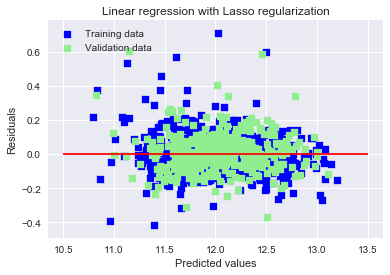

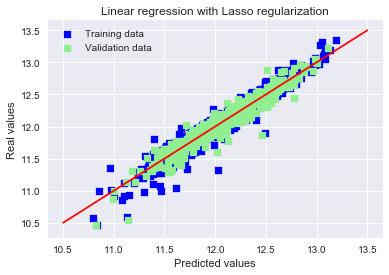

Lasso picked 116 features and eliminated the other 204 features


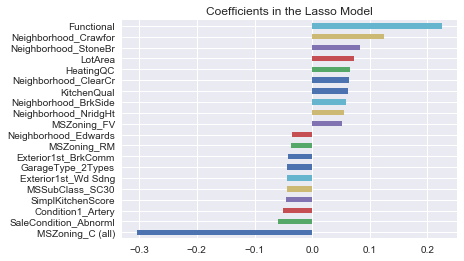

In [35]:
# 3* Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

## ここからロッソ回帰を実践

In [36]:
# ベストなalphaを適用
clf = Lasso(alpha=0.00045)

In [37]:
clf.fit(train, y)

/Users/ONORAN/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.00045, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [38]:
# この段階ではまだ対数変換されたpriceだから・・・
log_price = clf.predict(test)

In [39]:
# 対数変換を解く
price = np.expm1(log_price)

In [40]:
submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": price
    })

In [41]:
submission.to_csv('./submission.csv', index=False)